In [3]:
import numpy as np
import torch
from torch import nn
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet, convert_net_to_tropical

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import JuPyMake
JuPyMake.InitializePolymake()
JuPyMake.ExecuteCommand("application 'tropical';")

(True, '', '', '')

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
#simple linear neural network
class Net(torch.nn.Module):
    def __init__(self, inp_size, out_size, bias=True):
        super(Net, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(inp_size[0], out_size[0], bias=bias)])
        
        for i in range(1, len(inp_size)):
            self.linears.extend([nn.Linear(inp_size[i], out_size[i], bias=bias)])

    def forward(self, output):
        for i, l in enumerate(self.linears):
            output = l.forward(output)
            if i<len(self.linears)-1:
                output = torch.relu(output)#relu after each linear except last
        return output

In [8]:
torch.manual_seed(6)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Standart classification problem

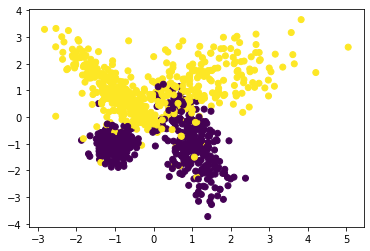

In [10]:
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles

X, Y = make_classification(n_samples=1000,n_features=2, n_redundant=0,
                           n_classes=2, random_state=5)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)   
x_t = torch.from_numpy(X).float()
y_t = torch.from_numpy(Y).long()

In [11]:
#network with two hidden layers
inp_size = [2,4,3]
out_size = [4,3,2]
model = Net(inp_size,out_size,bias=True)

epochs = 2000
batch_size = 100
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = torch.utils.data.TensorDataset(x_t, y_t)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


for epoch in range(epochs):
    loss_epoch = 0
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        loss_epoch += loss.item()
        
        opt.step()
        opt.zero_grad()
    
    if epoch%100 == 0:
        with torch.no_grad():
            acc = (model.forward(x_t).argmax(1)==y_t.flatten()).float().mean().item()
        print('Epoch: ', epoch, ' loss: ', loss_epoch, 'acc: ', acc)

Epoch:  0  loss:  7.698830723762512 acc:  0.5
Epoch:  100  loss:  2.30622960627079 acc:  0.9190000295639038
Epoch:  200  loss:  2.2222298681735992 acc:  0.9190000295639038
Epoch:  300  loss:  2.140708848834038 acc:  0.9210000038146973
Epoch:  400  loss:  2.093585714697838 acc:  0.9200000166893005
Epoch:  500  loss:  1.9553825408220291 acc:  0.9269999861717224
Epoch:  600  loss:  1.8315853774547577 acc:  0.9279999732971191
Epoch:  700  loss:  1.774931125342846 acc:  0.9309999942779541
Epoch:  800  loss:  1.7354308441281319 acc:  0.9300000071525574
Epoch:  900  loss:  1.718679964542389 acc:  0.9330000281333923
Epoch:  1000  loss:  1.7089613676071167 acc:  0.9330000281333923
Epoch:  1100  loss:  1.7031004875898361 acc:  0.9350000023841858
Epoch:  1200  loss:  1.6992222145199776 acc:  0.9350000023841858
Epoch:  1300  loss:  1.6962089464068413 acc:  0.9340000152587891
Epoch:  1400  loss:  1.693816564977169 acc:  0.9350000023841858
Epoch:  1500  loss:  1.6920469477772713 acc:  0.935000002384

# Quantize weights of network

In [36]:
# import torch.quantization
# quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# for i in range(len(model.linears)):
#     model.linears[i].weight.data.copy_(quantized_model.linears[i].weight().data.int_repr())
#     model.linears[i].bias.data.copy_((model.linears[i].bias.data/quantized_model.linears[i].weight().q_scale()))

# print('New acc: ', (model.forward(x).argmax(1)==y.flatten()).float().mean())

In [12]:
M = 10

model.linears[0].weight.data.copy_((model.linears[0].weight*M).int())
model.linears[1].weight.data.copy_((model.linears[1].weight*M).int())
model.linears[2].weight.data.copy_((model.linears[2].weight*M).int())

model.linears[0].bias.data.copy_((model.linears[0].bias*M).int())
model.linears[1].bias.data.copy_((model.linears[1].bias*M).int())
model.linears[2].bias.data.copy_((model.linears[2].bias*M).int())

print('New acc: ', (model.forward(x).argmax(1)==y.flatten()).float().mean().item())

New acc:  0.9100000262260437


In [13]:
model.linears[0].weight.data,model.linears[1].weight.data

(tensor([[-4., -1.],
         [13.,  8.],
         [-9., -3.],
         [ 3.,  7.]]),
 tensor([[ 10.,   7.,  -7.,  -2.],
         [ 10.,  11.,   5., -20.],
         [ -9.,   0.,  13.,  10.]]))

# Convert to tropical

In [14]:
h,g = convert_net_to_tropical(model)

In [15]:
h0_min = h[0].minimize()
h1_min = h[1].minimize()
g0_min = g[0].minimize()
g1_min = g[1].minimize()

In [16]:
h0_min

5115.0⨀a^4203⨀b^1401 ⨁ 6015.0⨀a^5203⨀b^2901 ⨁ 5975.0⨀a^6998⨀b^3121 ⨁ 6435.0⨀a^6568⨀b^3741 ⨁ 5415.0⨀a^3753⨀b^1251 ⨁ 6275.0⨀a^6548⨀b^2971 ⨁ 919.0⨀a^4672⨀b^1402 ⨁ 5295.0⨀a^4948⨀b^2946 ⨁ 4395.0⨀a^3408⨀b^1086 ⨁ 4695.0⨀a^3498⨀b^1296 ⨁ 2409.0⨀a^8032⨀b^4107 ⨁ -11.0⨀a^6067⨀b^1867 ⨁ 849.0⨀a^8862⨀b^3587

In [17]:
g0_min

2376.0⨀a^5203⨀b^1651 ⨁ 4676.0⨀a^5893⨀b^3261 ⨁ 630.0⨀a^5122⨀b^1552 ⨁ 7082.0⨀a^3724⨀b^3906 ⨁ 2382.0⨀a^2314⨀b^616 ⨁ 3006.0⨀a^4258⨀b^1336 ⨁ 5306.0⨀a^4948⨀b^2946 ⨁ 4580.0⨀a^7477⨀b^5157 ⨁ a^6067⨀b^1867 ⨁ 2300.0⨀a^6757⨀b^3477

In [18]:
h1_min

10.0⨀a^7032⨀b^2160 ⨁ 9336.0⨀a^5109⨀b^5611 ⨁ 7264.0⨀a^6537⨀b^4491 ⨁ 6802.0⨀a^7230⨀b^4722 ⨁ 6690.0⨀a^9078⨀b^6934 ⨁ 4030.0⨀a^8238⨀b^4974 ⨁ 2516.0⨀a^3063⨀b^837 ⨁ 3244.0⨀a^5331⨀b^1677 ⨁ 2782.0⨀a^6024⨀b^1908 ⨁ 472.0⨀a^6339⨀b^1929

In [19]:
g1_min

a^7032⨀b^2160 ⨁ 7786.0⨀a^7687⨀b^3611 ⨁ 7254.0⨀a^6537⨀b^4491 ⨁ 5894.0⨀a^3716⨀b^1202 ⨁ 6642.0⨀a^3969⨀b^1323 ⨁ 1032.0⨀a^5484⨀b^1644 ⨁ 8090.0⨀a^7725⨀b^5074 ⨁ 4108.0⨀a^9173⨀b^5436 ⨁ 6114.0⨀a^3782⨀b^1356 ⨁ 7216.0⨀a^8542⨀b^3896 ⨁ 6072.0⨀a^4824⨀b^1608 ⨁ 1144.0⨀a^10750⨀b^4448 ⨁ 7782.0⨀a^6724⨀b^4458

# Newton polygons and their subdivisions of first coordinate polynomials

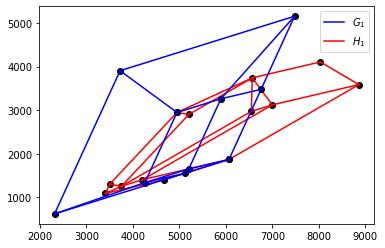

In [20]:
h0_min.plot_dual_sub(color='red',label='$H_1$')

g0_min.plot_dual_sub(color='blue',label='$G_1$')

# Newton polygons and their subdivisions of second coordinate polynomials

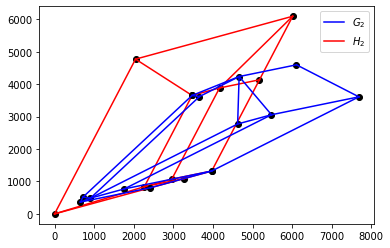

In [23]:
h1_min.plot_dual_sub(color='red',label='$H_2$')

g1_min.plot_dual_sub(color='blue',label='$G_2$')

# Create super-polynomial and it's components

In [21]:
h0g1_min = (h0_min*g1_min).minimize()

In [22]:
h1g0_min = (h1_min*g0_min).minimize()

In [23]:
R = h0g1_min + h1g0_min

In [24]:
R_min = R.minimize()

# Subdivisions of their Newton polygons

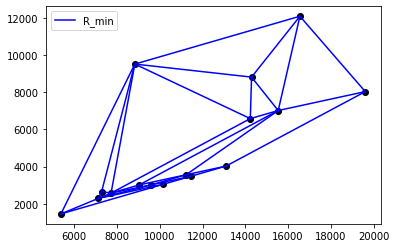

In [25]:
R_min.plot_dual_sub(color='blue',label='R_min')

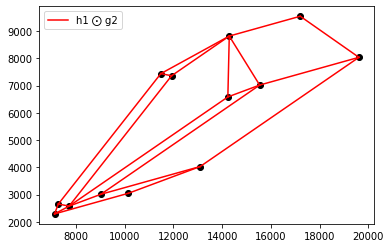

In [26]:
h0g1_min.plot_dual_sub(color='red',label='h1 ⨀ g2')

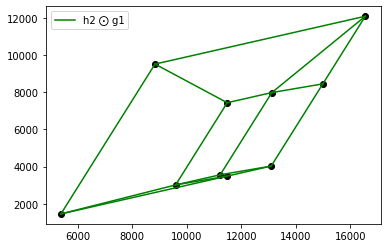

In [27]:
h1g0_min.plot_dual_sub(color='green',label='h2 ⨀ g1')

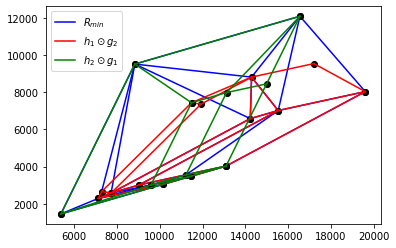

In [28]:
R_min.plot_dual_sub(color='blue',label='$R_{min}$')
h0g1_min.plot_dual_sub(color='red',label='$h_1 \odot g_2$')
h1g0_min.plot_dual_sub(color='green',label='$h_2 \odot g_1$')

# Tropical curves

(-5, 5)

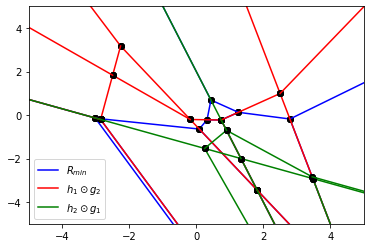

In [29]:
R_min.plot_curve(color='blue', label='$R_{min}$')
h0g1_min.plot_curve(color='red', label = '$h_1 \odot g_2$')
h1g0_min.plot_curve(color='green', label='$h_2 \odot g_1$')

plt.xlim([-5,5])
plt.ylim([-5,5])

# Let's visualize numerically estimated decision boundary of network

In [31]:
def plot_decision_boundary(model, rang, pred_func):
    xx,yy = np.meshgrid(np.arange(*rang), np.arange (*rang))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
#     plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.forward(x)
    return ans.argmax(1).float().detach().numpy()

def predict_poly(xx):
    xx = xx.tolist()
    out = []
    for x in xx:
        y0 = h0_min.evaluate(x).val - g0_min.evaluate(x).val
        y1 = h1_min.evaluate(x).val - g1_min.evaluate(x).val
        out.append(1 - (y0>y1))
    return np.array(out)

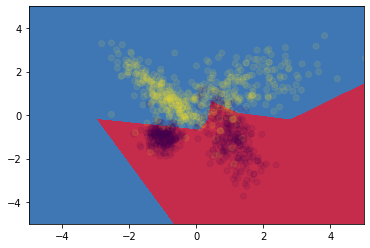

In [35]:
plot_decision_boundary(model, (-5, 5, 0.0005), predict)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, alpha=0.1)

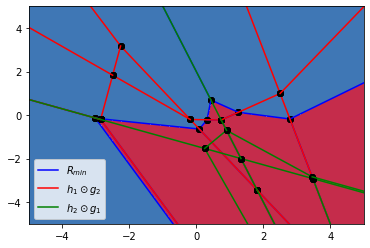

In [34]:
R_min.plot_curve(color='blue', label='$R_{min}$')
h0g1_min.plot_curve(color='red', label = '$h_1 \odot g_2$')
h1g0_min.plot_curve(color='green', label='$h_2 \odot g_1$')
plot_decision_boundary(model, (-5, 5, 0.005), predict)

In [36]:
pred = model.forward(x_t).argmax(1)

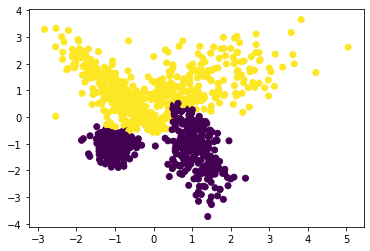

In [37]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=pred.detach().numpy().flatten())   